## CNN 2D <a name = "cnn_2d"></a>

Uma CNN 2D é um tipo de rede neuronal profunda projetada para analisar dados organizados em duas dimensões — como espectrogramas, geralmente interpretados como imagens. Esse tipo de modelo consegue explorar padrões tanto no domínio temporal quanto no domínio das frequências, extraindo estruturas locais que são essenciais para tarefas de classificação, detecção ou segmentação de eventos sonoros.

Ao processar um espectrograma, a CNN 2D é capaz de identificar características acústicas como harmónicos, variações súbitas de energia, mudanças de timbre, ataques e decaimentos de sons, além de padrões recorrentes associados a diferentes fontes sonoras. Graças aos seus filtros convolucionais, o modelo aprende representações robustas que tornam a análise de sinais complexos mais eficiente e precisa.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path

# ======================================================
# CONFIG (Parâmetros Focados em Performance)
# ======================================================
DATA_DIR = Path("./preprocessed_data")
RESULTS_DIR = Path("./results_optimized_v2") # Nova pasta para os novos resultados
FEATURE_TYPE = "mel_spec" 
NUM_FOLDS = 10
NUM_CLASSES = 10
EPOCHS = 80 # Aumentei um pouco (EarlyStopping vai controlar)
BATCH_SIZE = 32
SEED = 42
L2_REGULARIZATION_RATE = 1e-4 # Taxa de L2 (Regularização)
INITIAL_LR = 1e-3 # Learning Rate inicial
# Parâmetros de Early Stopping e LR Reduction
ES_PATIENCE = 10 
RLRP_PATIENCE = 4 # Reduzi para reagir mais rápido a platôs

# Criar os diretorios com resultados
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Configurar as seeds para reprodutibilidade
tf.random.set_seed(SEED)
np.random.seed(SEED)

: 

### Pré-Processamento - 2D CNN <a name = "cnn_2d_pp"></a>

O pré-processamento mais intensivo (extração de features e normalização global) já foi assumido inicialmente. No caso do CNN 2D foi utilizado como FEATURE_TYPE o "mel_spec" que indica que o modelo foi projetado para trabalhar com Melspectrogramas. Estes são representações visuais de áudio que capturam a distribuição de energia espectral, aproximando a perceção humana da frequência (escala Mel).
Adicionou-se uma nova dimensão (o canal de cor, que é 1 para imagens em escala de cinza/espectrogramas) que transforma os dados no formato exigido pelas camadas Conv2D do Keras (H,W,1).
Foi ainda adotada a estratégia de 'cross-validation' com 10 folds, onde são usados 8 folds para treino, 1 para validação e 1 para teste. Isto permite que a performance do modelo no treino não seja específica de uma única divisão dos dados.


### Arquitetura do Modelo CNN 2D

O nosso objetivo é que a CNN 2D criada seja capaz de:

- Extrair padrões locais de tempo e frequência nos espectrogramas.
- Aprender representações hierárquicas progressivamente mais abstratas ao longo das camadas.
- Reduzir dimensionalidade com pooling enquanto preserva informações relevantes.
- Classificar as entradas nas classes-alvo.

De modo a alcançar esse objetivo e com base nos estudos decidimos definir a arquitetura do seguinte modo:

-**Entrada do Modelo**

- Dimensões:

        Os espectrogramas tem dimensões fixas, como (128, 173, 1):

        128: Número de bandas de Mel (frequência).
        173: Número de frames temporais (largura da "imagem").
        1: Canal único, já que os espectrogramas são representações em tons de cinza.



**Camadas Convolucionais**

- Número de camadas:

        Iremos usar 4 camadas.


- Filtros e tamanhos:

        Primeira camada: 32 filtros, kernel (3x3).
        Segunda camada: 64 filtros, kernel (3x3).
        Terceira camada: 128 filtros, kernel (3x3).
        Quarta camada: 256 filtros, kernel (3x3)
        
- Aumento de capacidade: o número de filtros é duplicado a cada bloco (32 -> 64 -> 128 -> 256), aumento, assim, a capacidade do modelo extrair features mais complexas.

- Pooling (MaxPooling2D): reduz a dimensionalidade espacial, tornando o modelo mais robusto a pequenas translações nos dados de entrada.

- Global Average Pooling (GAP): O modelo usa 'layers.GlobalAveragePooling2D()' em vez de Flatten seguido por camadas Dense gigantes; este Gap calcula a média de cada mapa de feature, resultando em um vetor de features de tamanho (1, 256) (para o último bloco de 256 filtros). Esta tecnica reduz drasticamente o número de parâmetro e previne overfitting.

- Dropout: Com o objetivo de evitar overfitting e melhorar a generalização, ocorreu o aumento do dropout ao longo das camadas. Assim, é aplicado um dropout de 0.1 na primeira e segunda camada que vai aumentando para 0.2 na terceira camada e , por fim, de 0.3 antes da camada de saída.

- Camada de Saída: Uma camada 'Dense' com ativação Softmax classifica os dados nas 10 'NUM_CLASSES'.






**Função de ativação**

Usamos ELU (layers.Activation('elu')) que tende a melhorar a performance por evitar o problema de 'dying ReLU' e manter as saídas das camadas mais próximas de 0.
Para a inicialização dos pesos foi utilizado 'he_normal' que é recomendada para esta função de ativação.

**Regularização L2**

É aplicada a regularização L2 nas camadas convolucionais e densas, o que vai permitir a penalização dos pesos grandes para ajudar a prevenir o overfitting.

**Batch Normalization**
 
Aplicada antes da ativação e vai permitir as ativações de cada mini-batch, acelerando o treino e permitindo o uso de tavas de aprendizagem (L/R) maiores.










In [ ]:
def build_ultra_optimized_cnn(input_shape, num_classes=NUM_CLASSES):
    """
    Constrói o modelo CNN 2D otimizado com ELU, BatchNormalization, L2 Regularization,
    e arquitetura simplificada pós-Global Average Pooling.
    """
    model = models.Sequential()
    l2_reg = regularizers.l2(L2_REGULARIZATION_RATE) # Taxa de L2

    # --- Bloco Convolucional 1 ---
    # Kernel: he_normal é bom para ELU/ReLU
    model.add(layers.Conv2D(32, (3,3), padding='same', input_shape=input_shape, 
                            kernel_initializer='he_normal', kernel_regularizer=l2_reg))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu')) # Melhor que ReLU
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.1))

    # --- Bloco Convolucional 2 ---
    model.add(layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.1))

    # --- Bloco Convolucional 3 ---
    model.add(layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))
    
    # --- Bloco Convolucional 4 (Mais profundo) ---
    model.add(layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    
    # Substitui Flatten + Dense Gigante
    model.add(layers.GlobalAveragePooling2D()) 
    model.add(layers.Dropout(0.3)) # Aumento do dropout aqui (após GAP)

    # --- Camada Densa Final (Simplificada) ---
    # Reduzindo o número de camadas densas para evitar overfitting excessivo pós-GAP
    
    #  Opcional: Uma camada densa pequena antes da saída
    # model.add(layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=l2_reg))
    # model.add(layers.BatchNormalization())
    # model.add(layers.Activation('elu'))
    # model.add(layers.Dropout(0.3))
    
    # --- Output ---
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Otimizador com LR ajustável
    model.compile(
        optimizer=optimizers.Adam(learning_rate=INITIAL_LR),
        loss='sparse_categorical_crossentropy', # Mantido, se labels forem inteiros
        metrics=['accuracy']
    )

    return model

### Estratégia de treino do CNN 2D

**Função de Perda (Loss Function)**

        escolha: sparse_categorical_crossentropy

Decidimos usar esta função, uma vez que é apropriada quando os labels da classe são inteiros, ou seja, estamos a lidar com um problema de classificação multi-classe (10 classes) e esta função é padrão para tarefas onde as saídas são probabilidades (softmax).

**Otimizador**

        Escolha: Adam

Foi ainda aplicado com uma taxa de aprendizagem inicial de 0.001.
O Adam combina as vantagens de RMSProp e Momentum, adaptando a taxa de aprendizagem para cada parâmetro. É amplamente usado e mostrou ser eficiente em CNNs para dados similares. 

**Hiperparâmetros de Treinamento**

Os valores aqui escolhidos foram testados mais que uma vez e variados, sendo que os obtiveram melhor resultado são os aqui escolhidos.

- Learning rate

        Inicialmente será definido como 0.001

Apesar de termos feitos diversos testes com diferentes valores como 0.001, 0.0005 e 0.0001, o que apresentou melhores resultados foi 0.001.

- Mini-batch Size:

        Tamanho 32

É um valor intermediário que equilibra o desempenho computacional e estabilidade de treinamento. Também testamos com 64, mas não obtivemos grandes alterações.

- Número de Épocas:

        Inicialmente 80
    
Também foram testados os valores de 50 e 60 mas 80 foi o que obteve melhores resultados.

Será combinado com Early Stopping.

**Data Augmentation**

Houve uma tentativa implementação de data augmentation no treino usando técnicas de SpecAugment, que simulam variações no tempo e na frequência do áudio. Estas adicionavam duas camadas ao pré-processamento: Time Masking e Frequency Masking.

**Monitoramento**

- ModelCheckpoint: o modelo é salvo se a métrica de validação da accuracy for a melhor observada até ao momento.

- ReduceLROnPlateau(RLRP): monitoriza a val_loss. Se a perda de validação estagnar por 4 épocas, o learning rate é reduzido a metade(factor=0.5).

- Early Stopping: monitoriza a métrica de validação. Se a perda de validação estagnar por 10épocas, o treino é parado e os melhores pesos são usados (guardados em 'ModelCheckpoint' e restaurados por 'restore_best_weights=True'). Isto evita o overfitting e economiza tempo de execução.



In [ ]:
def train_fold(fold):
    print(f"\n======================")
    print(f" TRAINING FOLD {fold}")
    print(f"======================")

    # Carregar os dados
    try:
        X_train, y_train, X_val, y_val, X_test, y_test = load_fold_data(fold)
    except FileNotFoundError as e:
        print(e)
        return None 
    
    # Carregar nomes das classes para o relatório de classificação, se existirem (assumindo que não)
    class_names = [str(i) for i in range(NUM_CLASSES)]
    
    input_shape = X_train.shape[1:] 
    print(X_train.shape)
    model = build_ultra_optimized_cnn(input_shape)

    # Calcular pesos das classes para lidar com desbalanceamento (Essencial)
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Callbacks (Paciência ajustada para melhor convergência)
    checkpoint_path = RESULTS_DIR / f"best_model_fold{fold}.keras"
    checkpoint = callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0 # Mudei para 0 para output mais limpo
    )
    # Reduzir LR se não melhorar
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=RLRP_PATIENCE, verbose=1, min_lr=1e-6
    )
    # Parar cedo se não melhorar
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss', patience=ES_PATIENCE, restore_best_weights=True, verbose=1
    )

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weights_dict,
        callbacks=[checkpoint, reduce_lr, early_stop],
        verbose=2 # 1 para log por época, 2 para um log mais limpo
    )
    
    # Gerar gráficos de treino
    plot_history(history, fold)

    # Evaluate on test split
    print(f"Evaluating Fold {fold}...")
    # Carregar o melhor modelo salvo
    try:
        best_model = models.load_model(checkpoint_path)
    except Exception as e:
        print(f"Erro ao carregar o melhor modelo: {e}. Usando o modelo treinado.")
        best_model = model
    
    preds_probs = best_model.predict(X_test, verbose=0)
    preds = np.argmax(preds_probs, axis=1)

    # Relatório e Matriz de Confusão
    print("\nClassification Report:")
    print(classification_report(y_test, preds, digits=4, target_names=class_names))
    
    plot_confusion_matrix(y_test, preds, fold, class_names=class_names)

    acc = np.mean(preds == y_test)
    print(f"Fold {fold} Test Accuracy = {acc:.4f}")

    return acc

Esta função tem como objetivo carregar corretmente os dados para os fornecer ao modelo.

In [ ]:
def load_fold_data(fold):
    fold_dir = DATA_DIR / f"fold_{fold}"

    try:
        X_train = np.load(fold_dir / FEATURE_TYPE / "X_train.npy")
        X_val   = np.load(fold_dir / FEATURE_TYPE / "X_val.npy")
        X_test  = np.load(fold_dir / FEATURE_TYPE / "X_test.npy")
    except FileNotFoundError:
        raise FileNotFoundError(f"Não encontrei dados para '{FEATURE_TYPE}' em {fold_dir}. Verificar se a pasta existe ou altera o FEATURE_TYPE no código.")
    
    y_train = np.load(fold_dir / "y_train.npy")
    y_val   = np.load(fold_dir / "y_val.npy")
    y_test  = np.load(fold_dir / "y_test.npy")

    # Adicionar dimensão do canal (H, W, 1)
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]   

    return X_train, y_train, X_val, y_val, X_test, y_test


**Métricas de Avaliação**

Após o treino, o melhor modelo é salvo, carregado e avaliado no conjunto de teste ('X_test').
Os resultados são dados sobre a forma de classification report e matriz de confusão.

In [ ]:
def plot_history(history, fold):
    """Gera gráficos de Loss e Accuracy"""
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    ax[0].plot(history.history['accuracy'], label='Train')
    ax[0].plot(history.history['val_accuracy'], label='Val')
    ax[0].set_title(f'Model Accuracy - Fold {fold}')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='lower right')
    ax[0].grid(True, alpha=0.3)
    
    # Loss
    ax[1].plot(history.history['loss'], label='Train')
    ax[1].plot(history.history['val_loss'], label='Val')
    ax[1].set_title(f'Fold {fold}-Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper right')
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"history_fold_{fold}.png", dpi=100)
    plt.close(fig)


def plot_confusion_matrix(y_true, y_pred, fold, class_names=None):
    """Gera e guarda a matriz de confusão"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    
    # Se tiver nomes de classes, use-os
    if class_names is not None:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_names, yticklabels=class_names)
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(RESULTS_DIR / f"cm_fold_{fold}.png", dpi=100)
    plt.close()

Por fim, executamos o código na sua totalidade e obteve-se os seguintes resultados.

In [ ]:
if __name__ == "__main__":
    # Verificar se as bibliotecas de plot existem
    try:
        import seaborn
        import matplotlib
    except ImportError:
        print("AVISO: Instala seaborn e matplotlib para veres os gráficos!")
        print("pip install seaborn matplotlib")

    accuracies = []
    for fold in range(1, NUM_FOLDS+1):
        acc = train_fold(fold)
        if acc is not None:
            accuracies.append(acc)

    if not accuracies:
        print("\nO treino não pôde ser iniciado. Verifique o seu diretório DATA_DIR e FEATURE_TYPE.")
        exit()
        
    print("\n======================")
    print(" 10-FOLD CV RESULTS (ULTRA OPTIMIZED MODEL)")
    print("======================")
    for i, a in enumerate(accuracies, 1):
        print(f"Fold {i}: acc = {a:.4f}")
    
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    
    print(f"\nMean accuracy = {mean_acc:.4f}")
    print(f"Std = {std_acc:.4f}")
    
    # Salvar resumo final num ficheiro de texto
    with open(RESULTS_DIR / "final_results.txt", "w") as f:
        f.write(f"Mean Accuracy: {mean_acc:.4f}\n")
        f.write(f"Std Dev: {std_acc:.4f}\n")
        f.write(f"Results per fold: {accuracies}\n")

### Resultados obtidos

**Confusion matrix por fold**

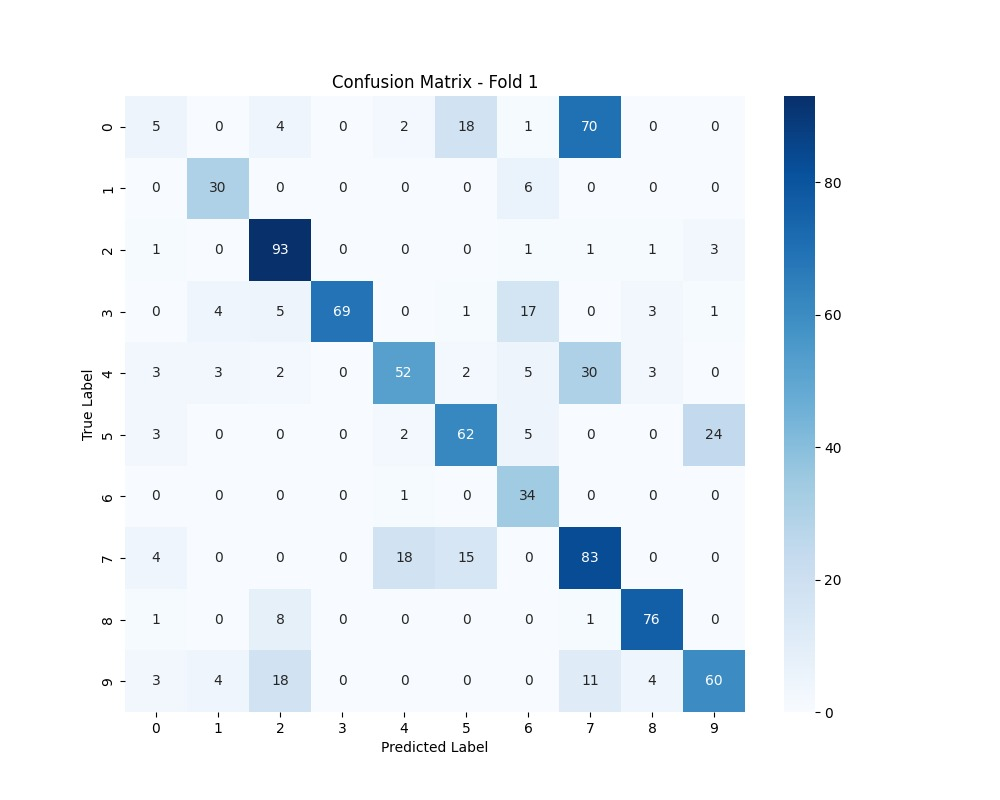 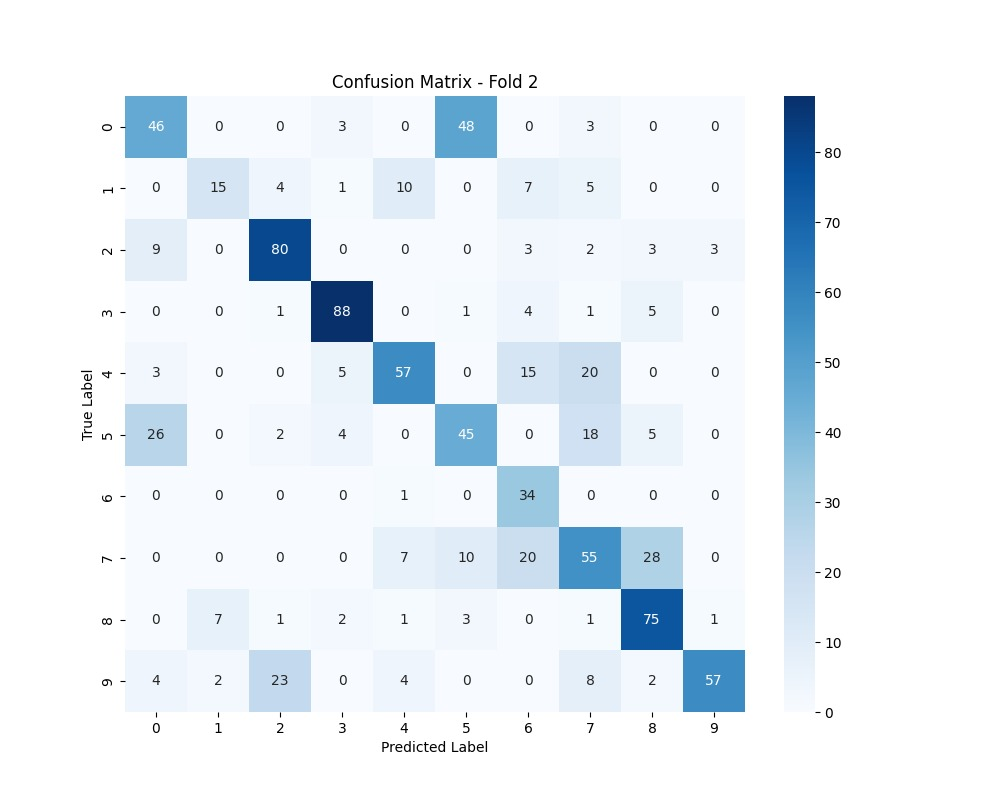 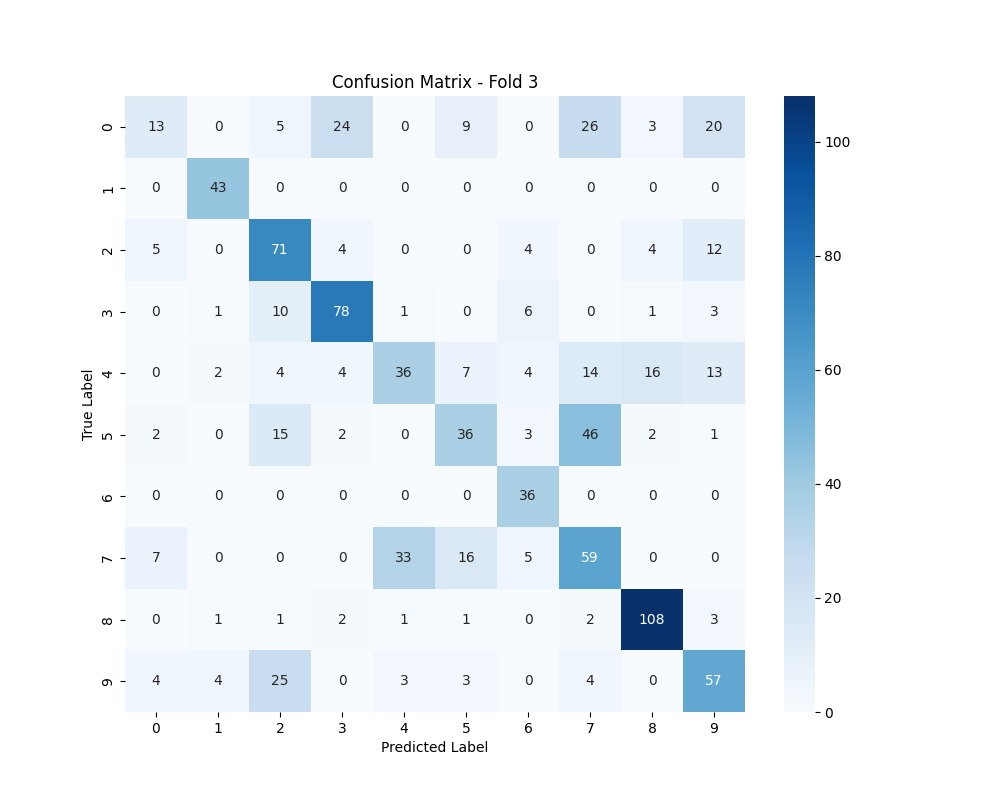 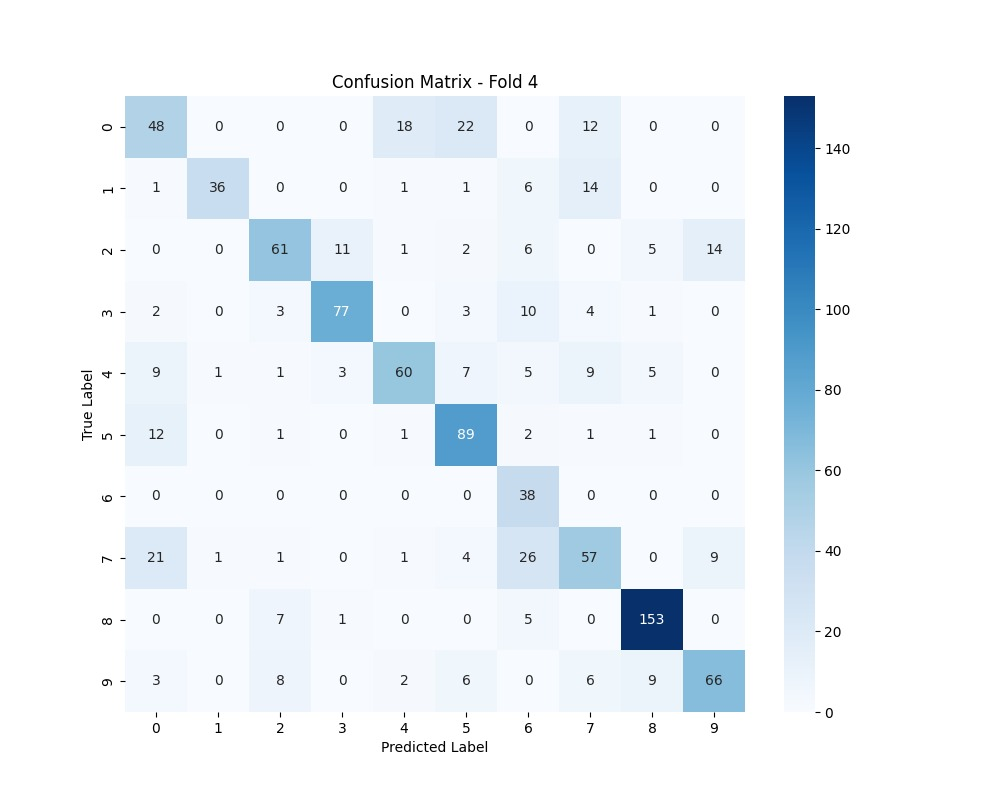 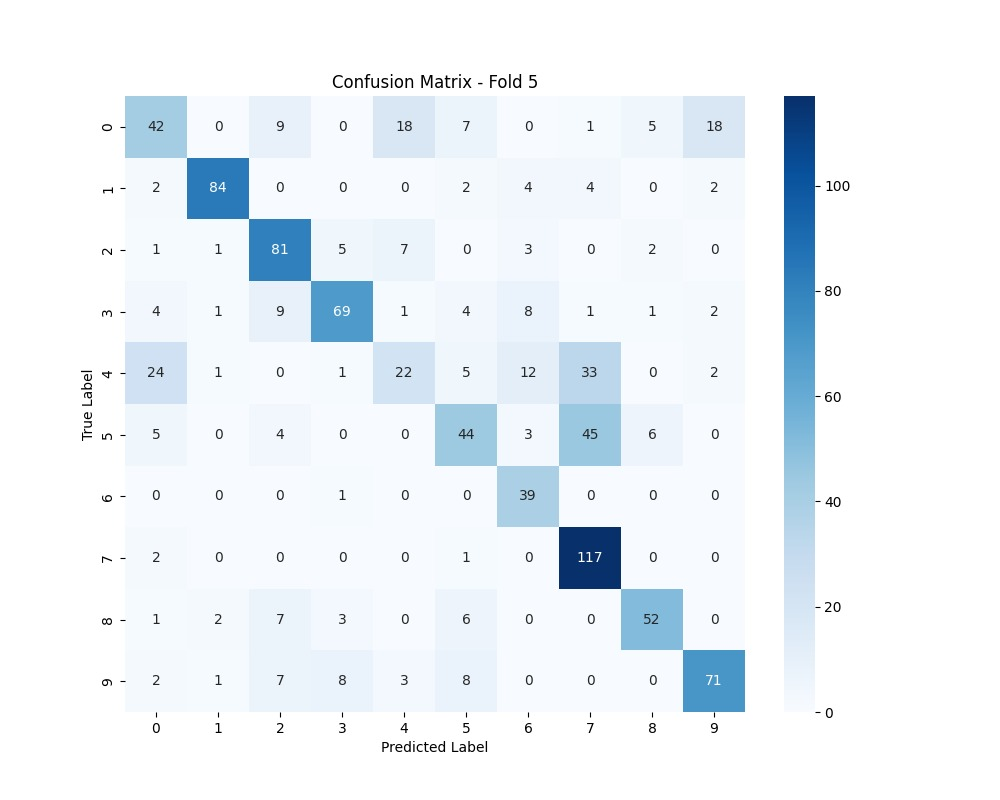 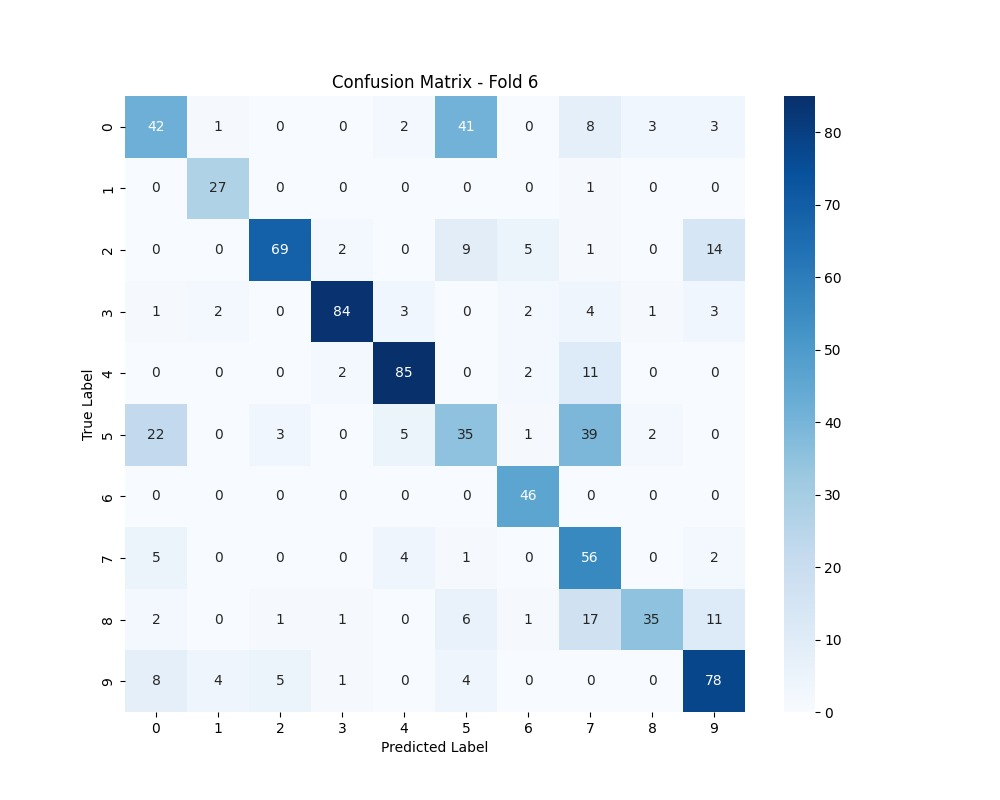 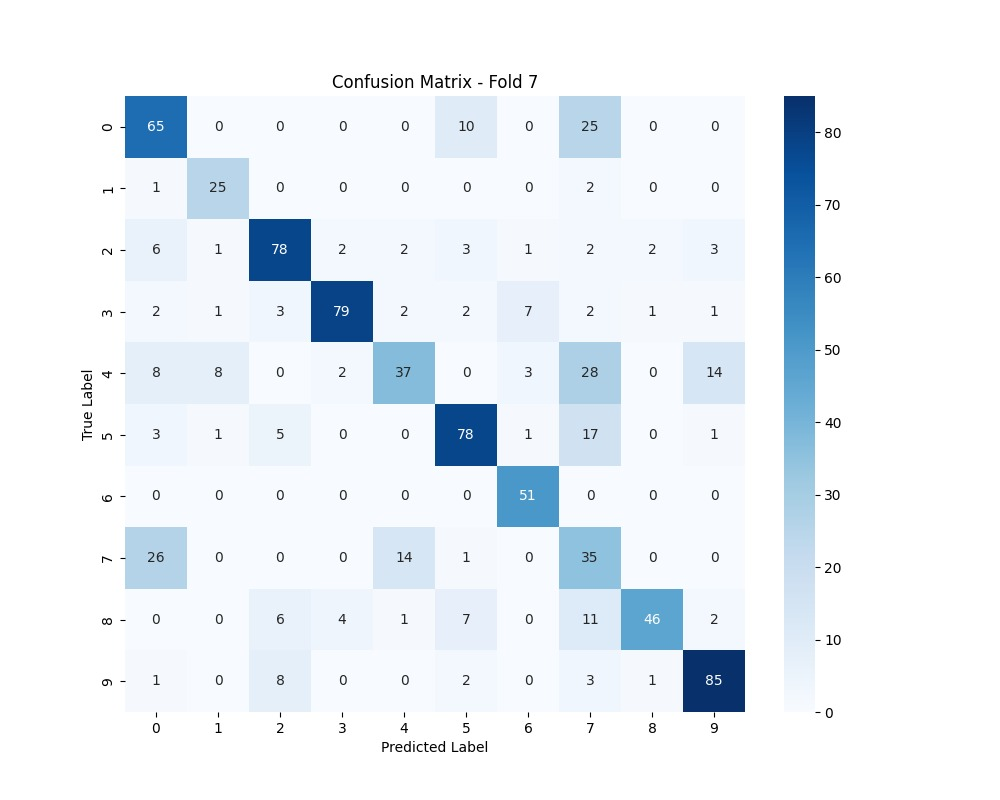 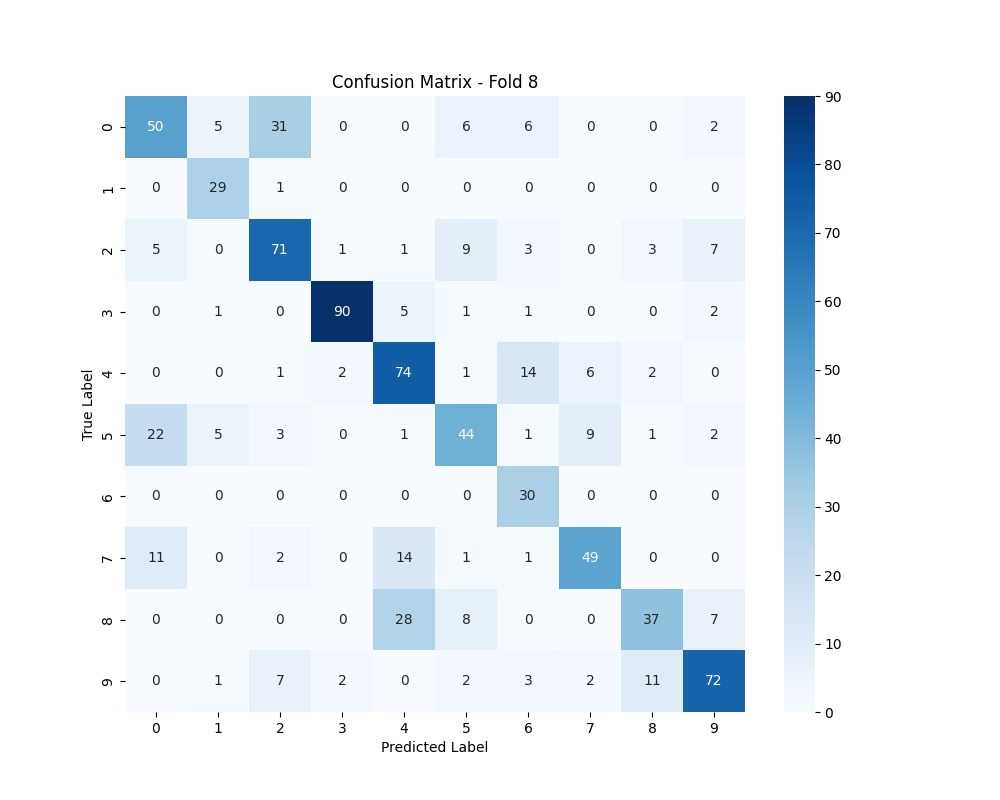 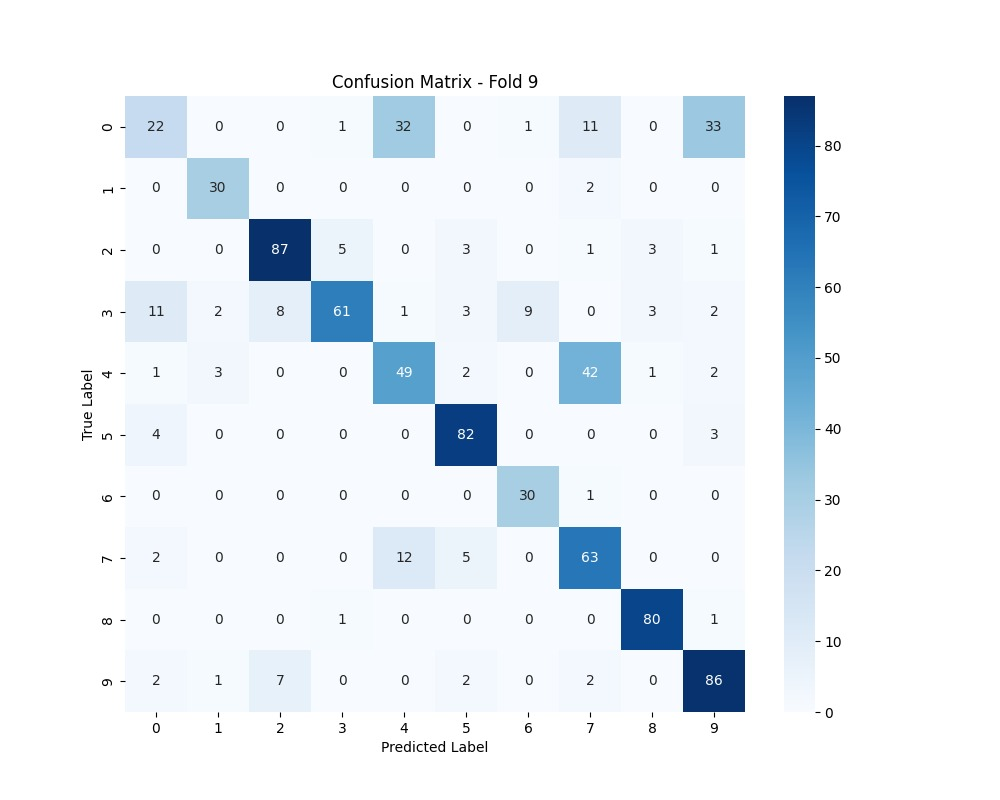 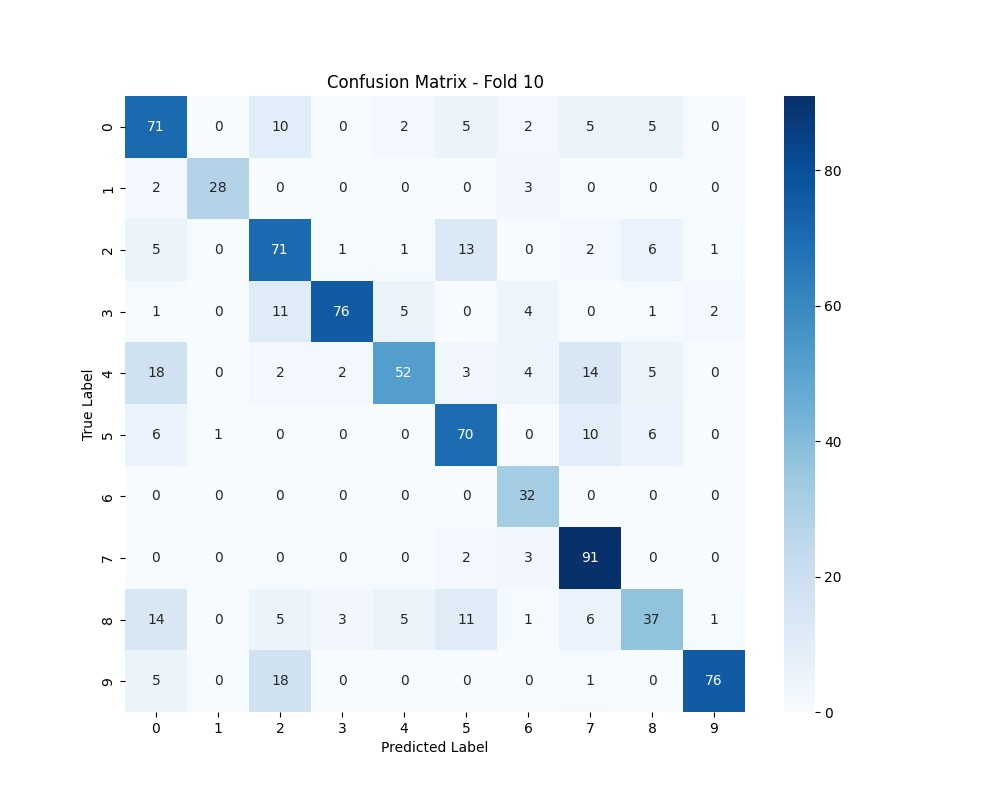 

**Gráficos da loss e accuracy por fold**


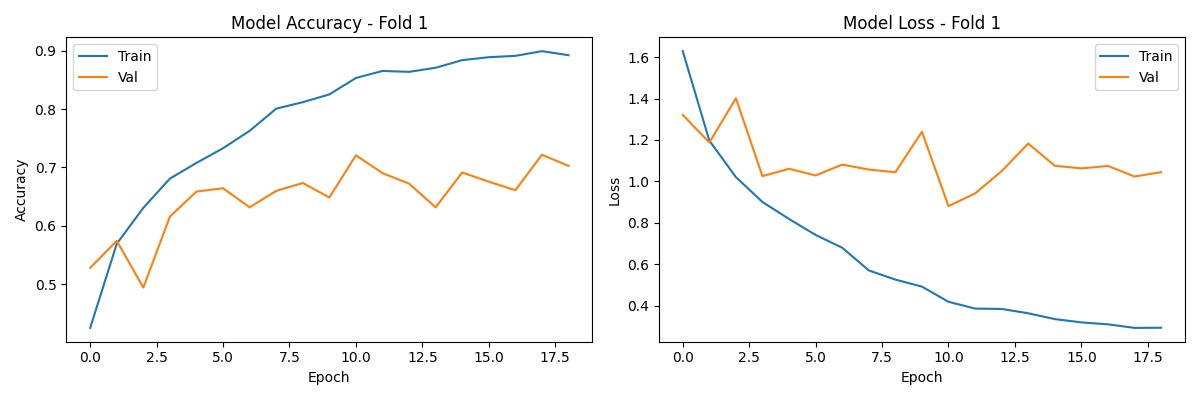 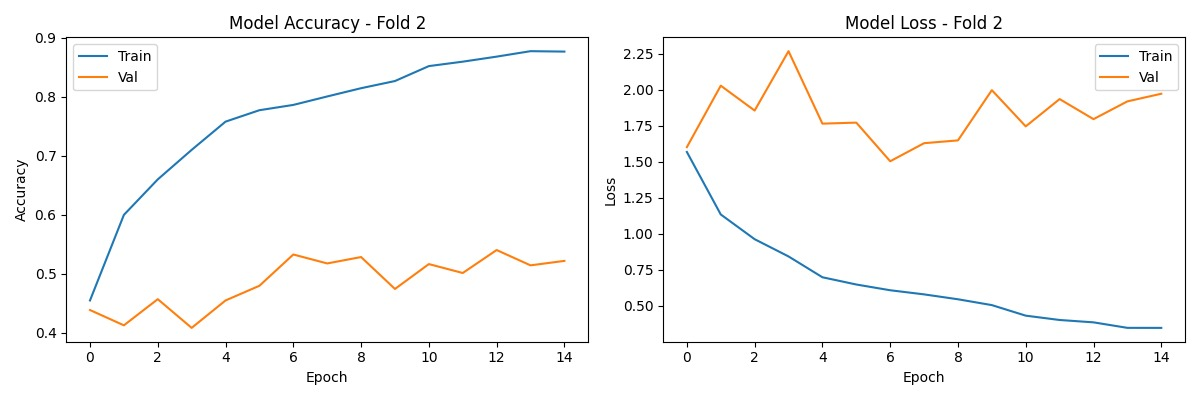 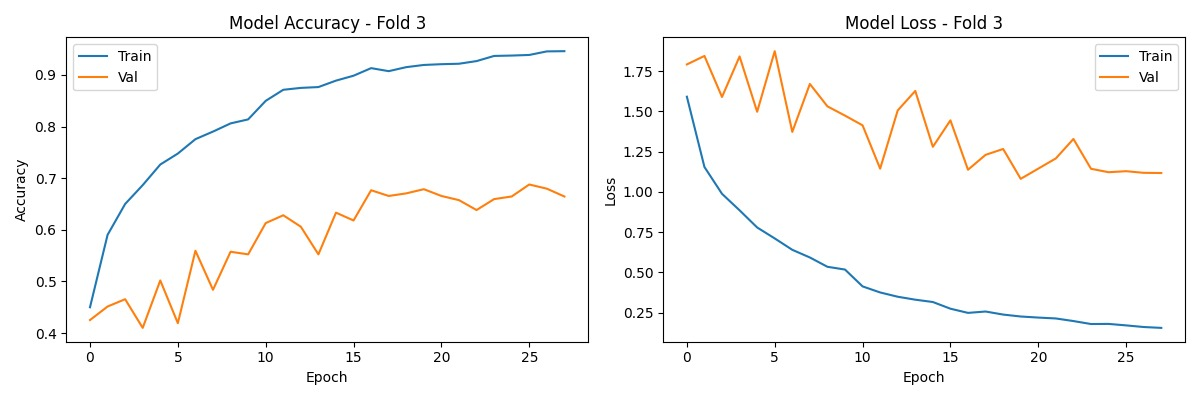 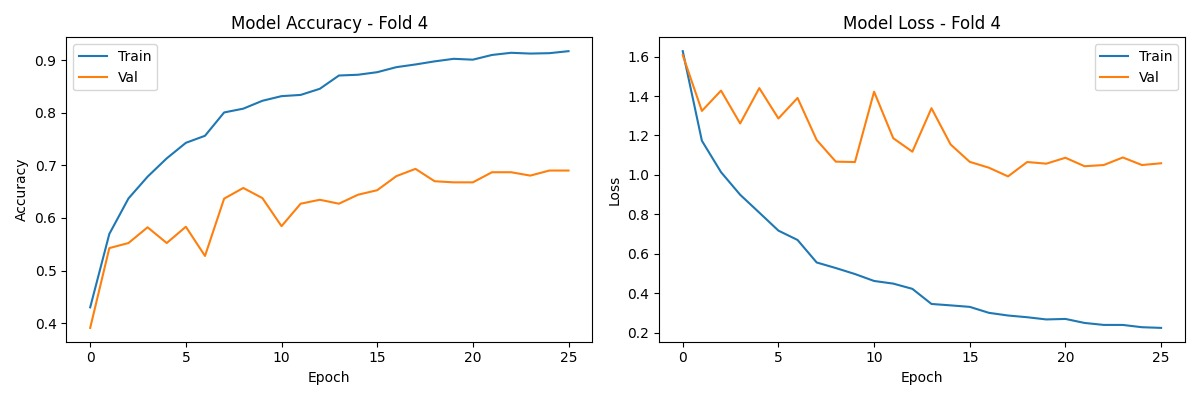 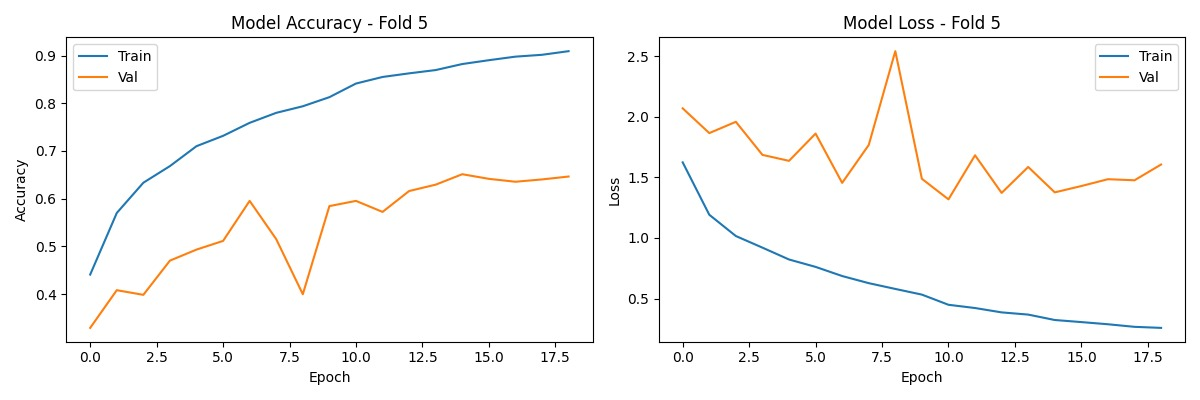 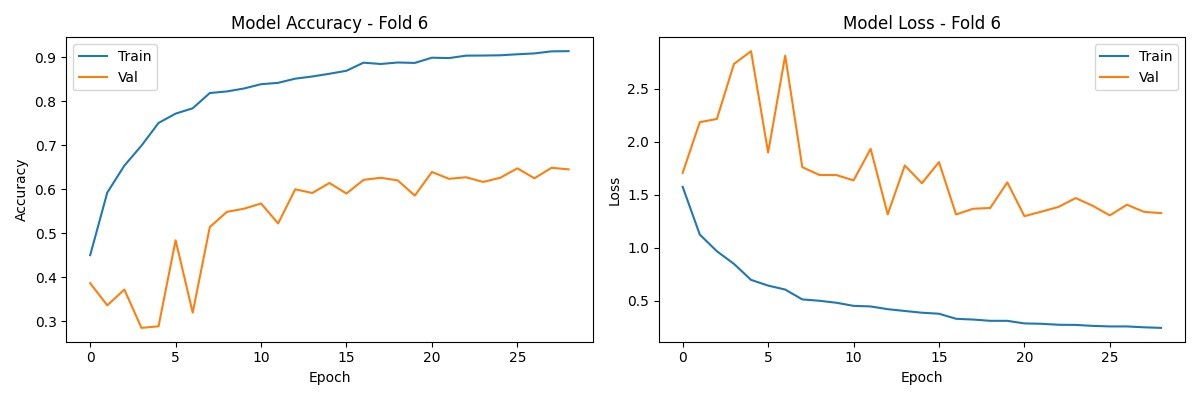 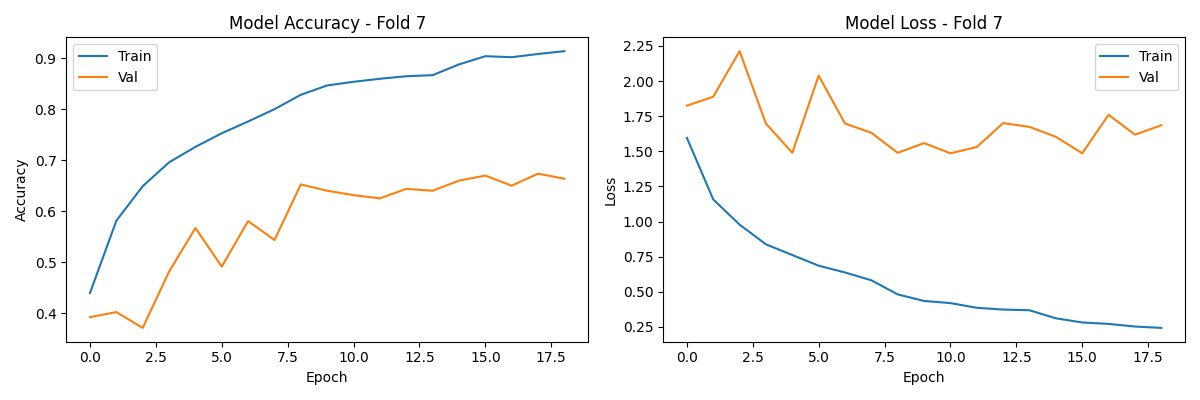 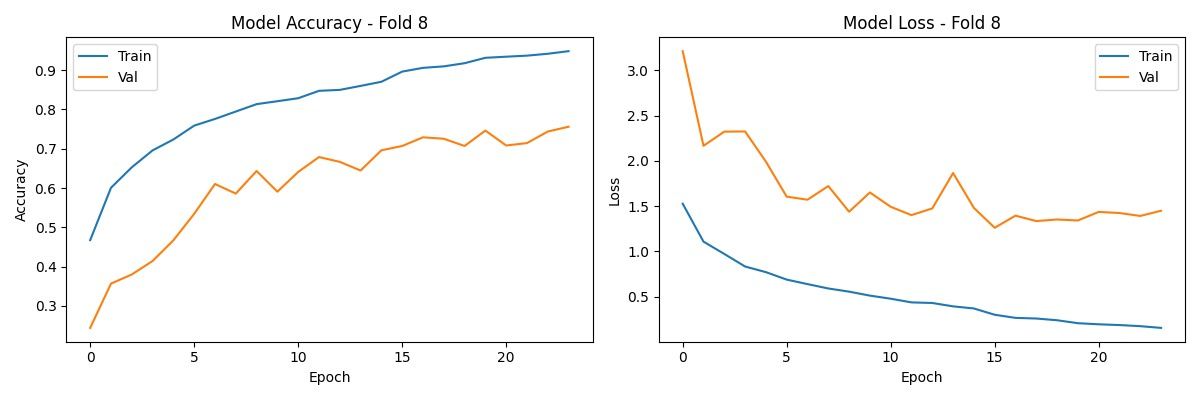 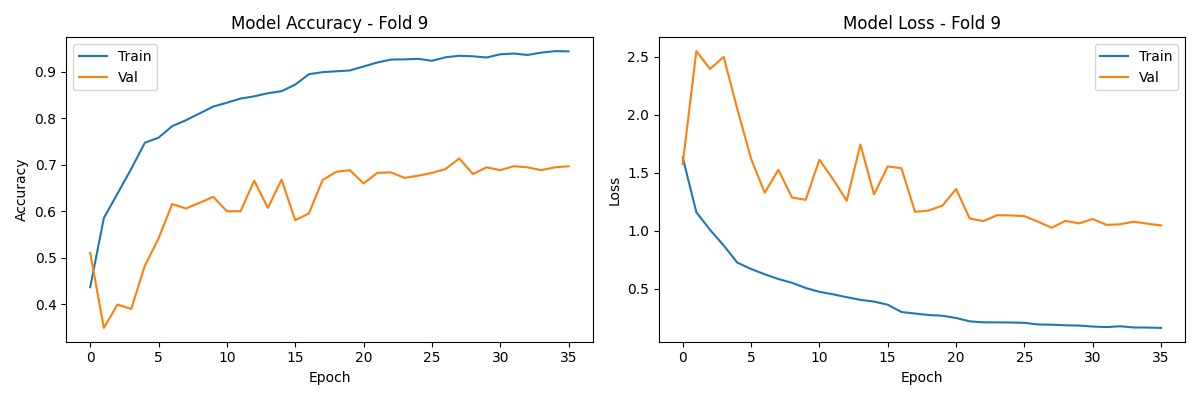 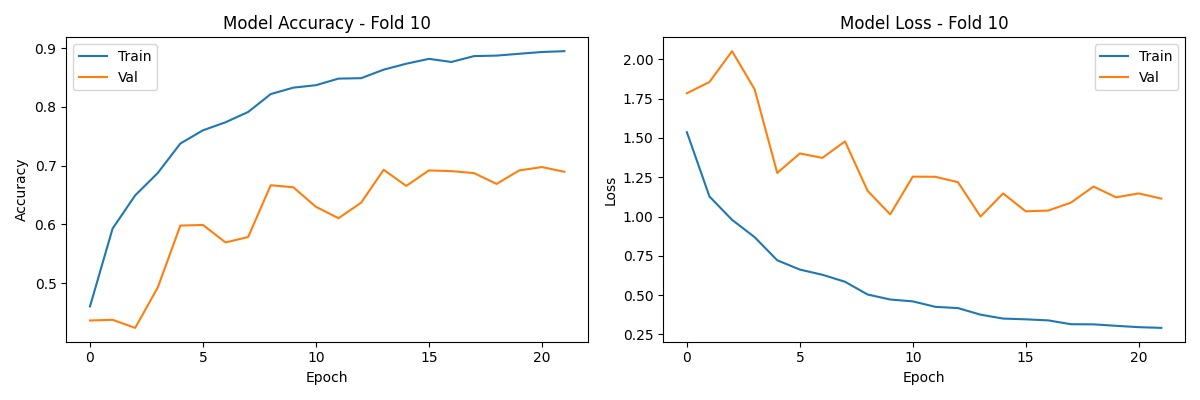

**Accuracy global**

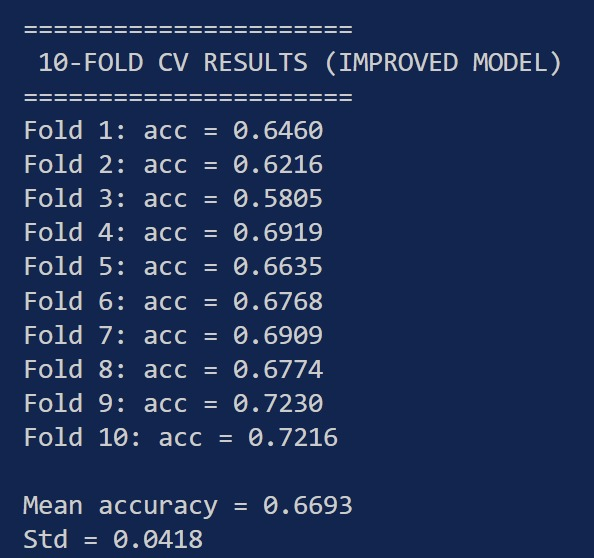

### Análise de resultados


**Matrizes de confusão**

As matrizes de confusão mostram um bom desempenho geral do modelo, especialmente nas classes 2(children_playing), 3(dog_bark), 5(engine_idling), 7(jack_hammer) e 9(street_music), que apresentam uma maior concentração de acertos na diagonal ao longo dos diferentes folds. Por sua vez, as classes 0(air_conditioner), 1(car_horn) e 8(siren) revelam resultados inferiores, com classificações distribuídas por diferentes categorias fora da diagonal. Observa-se ainda uma confusão recorrente entre as classes 0 e 7, o que é esperado devido à semelhança dos seus padrões acústicos.
No geral, o modelo mantém resultados consistentes entre os folds, distinguindo com maior precisão as classes com características sonoras mais marcadas.

**Análise dos gráficos**

A análise dos gráficos de treino e validação mostra que o modelo aprende de forma eficaz ao longo das épocas, atingindo valores de accuracy de treino entre 0.85 e 0.95 na maioria dos folds. No entanto, a accuracy de validação estabiliza mais cedo, normalmente entre 0.60 e 0.70, criando uma diferença significativa entre treino e validação.
Esse padrão também é evidente na loss: enquanto a loss de treino desce continuamente, a loss de validação apresenta pouca melhoria e flutua ao longo das épocas. Isto indica que, após certo ponto, o modelo começa a memorizar os dados de treino, caracterizando overfitting. Foi com base nestes resultados que decidimos implementar data augmentation, no entanto não foi possível obter os resultados para essa experiência.
Apesar desse fenómeno, o desempenho mantém-se relativamente consistente entre os diferentes folds, sugerindo que o modelo consegue capturar padrões relevantes, mas tem dificuldade em generalizar para amostras não vistas, especialmente devido à diversidade sonora presente no dataset.

**Accuracy global**

Os resultados do modelo ao longo dos 10 folds apresentam uma accuracy média de 0.6693, com um desvio-padrão reduzido (0.0418). Isto indica que o desempenho do modelo é relativamente consistente entre diferentes partições dos dados, sem grandes variações entre folds.

Observa-se ainda que os últimos folds atingem valores de accuracy mais elevados (acima de 0.70), sugerindo que o modelo generaliza melhor em subconjuntos específicos onde os sons apresentam características mais marcadas ou menor ruído de fundo.

No geral, estes resultados demonstram uma boa capacidade de generalização, embora ainda exista espaço para melhoria, sobretudo devido ao efeito de overfitting identificado nos gráficos de treino e validação.